In [1]:
# google_play_scraperのインストール
!pip install google_play_scraper

In [14]:
# ライブラリの読み込み
from google_play_scraper import app
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

In [21]:
# google_play_scraperでレビュー取得
from google_play_scraper import Sort, reviews_all

# 「Uber - Request a ride - Google Play」からレビューを取得する
jp_reviews = reviews_all(
    'com.ubercab.freight',
    sleep_milliseconds=0,  # defaults to 0
    lang='en',  # defaults to 'en'
    country='us',  # defaults to 'us'
    sort=Sort.NEWEST,  # defaults to Sort.MOST_RELEVANT
)

In [22]:
# 取得したレビューをデータフレームに格納
df_bush = pd.DataFrame(np.array(jp_reviews), columns=['review'])
df_bush = df_bush.join(pd.DataFrame(df_bush.pop('review').tolist()))

In [24]:
len(df_bush)

1370

## 01.月別スコアの集計


### 運用開始日から現在までのスコア推移を棒グラフで表示

In [25]:
df = df_bush[['at', 'score', 'content']]
df.head()

df.to_csv('Uber_Freight.csv', index=False)

In [27]:
df['score'].value_counts()  # ユニーク値（score）のカウント

5    649
1    446
4    109
2     86
3     80
Name: score, dtype: int64

In [26]:
# 月別でスコア数を表示
df_score = df[['at', 'score']]

# crosstableでscoreを横軸に変換
df_score = pd.crosstab(df['at'], df['score'], dropna=False)

# resampleで月毎に
df_score = df_score.resample('M').sum()

# 月別スコア データフレームを作成
df_score

score,1,2,3,4,5
at,,,,,
2017-03-31,4,0,0,0,2
2017-04-30,2,0,0,0,7
2017-05-31,3,1,0,0,4
2017-06-30,9,0,0,0,1
2017-07-31,2,0,0,0,1
...,...,...,...,...,...
2023-06-30,1,1,0,0,2
2023-07-31,5,1,0,0,3
2023-08-31,3,1,0,1,7


<Axes: xlabel='at'>

<Figure size 640x480 with 0 Axes>

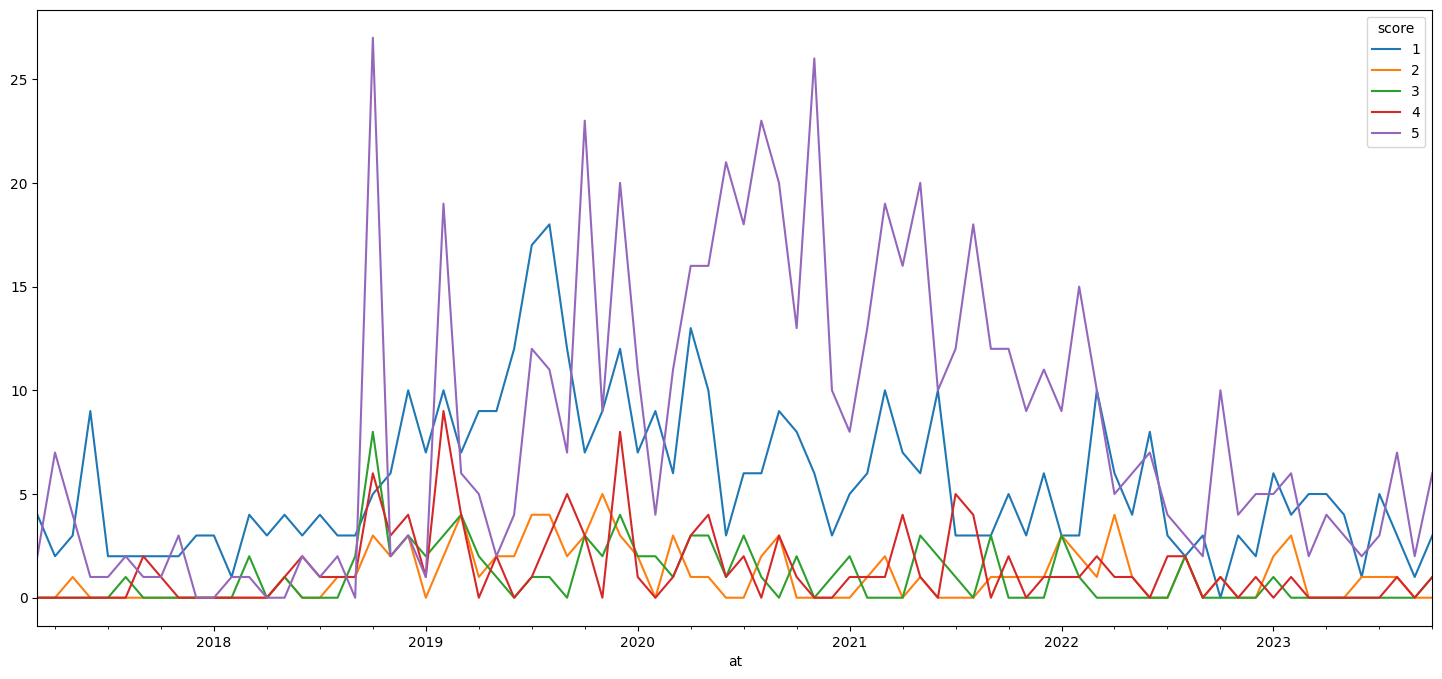

In [28]:
# plotで折れ線グラフを表示
plt.figure()
df_score.plot(figsize=(18,8))

### 100%積み上げ棒グラフで年別スコアを集計

In [31]:
# 100%積み上げグラフで表示
# 月別で集計
df_score_month = df_score.resample('Y').sum()
df_score_month

score,1,2,3,4,5
at,,,,,
2017-12-31,31,1,1,3,22
2018-12-31,49,11,18,19,39
2019-12-31,129,32,23,36,119
2020-12-31,86,12,19,16,189
2021-12-31,67,8,11,20,160
2022-12-31,47,14,6,12,80
2023-12-31,37,8,2,3,40


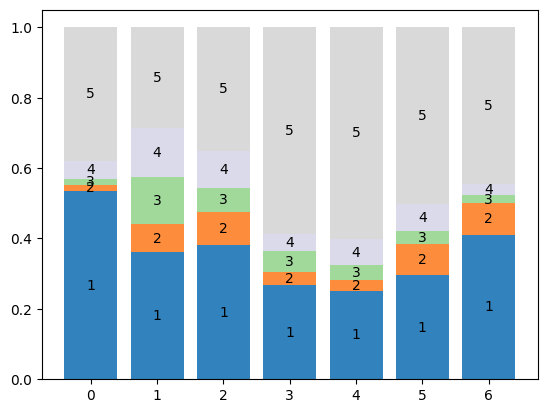

In [32]:
# 100%積み上げグラフ
# 正規化する
df_score_month2 = df_score_month.div(df_score_month.sum(axis=1), axis=0)

n_rows, n_cols = df_score_month2.shape
positions = np.arange(n_rows)
offsets = np.zeros(n_rows, dtype=df_score_month2.values.dtype)
colors = plt.get_cmap("tab20c")(np.linspace(0, 1, n_cols))

fig, ax = plt.subplots()
ax.set_xticks(positions)

for i in range(len(df_score_month2.columns)):
    # 棒グラフを描画する。
    bar = ax.bar(positions, df_score_month2.iloc[:, i], bottom=offsets, color=colors[i])
    offsets += df_score_month2.iloc[:, i]

    # 棒グラフのラベルを描画する。
    for rect in bar:
        cx = rect.get_x() + rect.get_width() / 2
        cy = rect.get_y() + rect.get_height() / 2
        ax.text(cx, cy, df_score_month2.columns[i], color="k", ha="center", va="center")


まだ折れ線グラフ・棒グラフの可視化から、リリースしてから３ヶ月足らずだが、評価が減少傾向にあることがわかった。

### 直近1カ月間のスコア推移とレビューの表示

In [33]:
# 2023年度のスコア推移とレビューの表示
date_start = "2023-01-01"

df_score_ex = df_score[date_start:]
df_score_ex

score,1,2,3,4,5
at,,,,,
2023-01-31,6,2,1,0,5
2023-02-28,4,3,0,1,6
2023-03-31,5,0,0,0,2
2023-04-30,5,0,0,0,4
2023-05-31,4,0,0,0,3
2023-06-30,1,1,0,0,2
2023-07-31,5,1,0,0,3
2023-08-31,3,1,0,1,7
2023-09-30,1,0,0,0,2


<Axes: xlabel='at'>

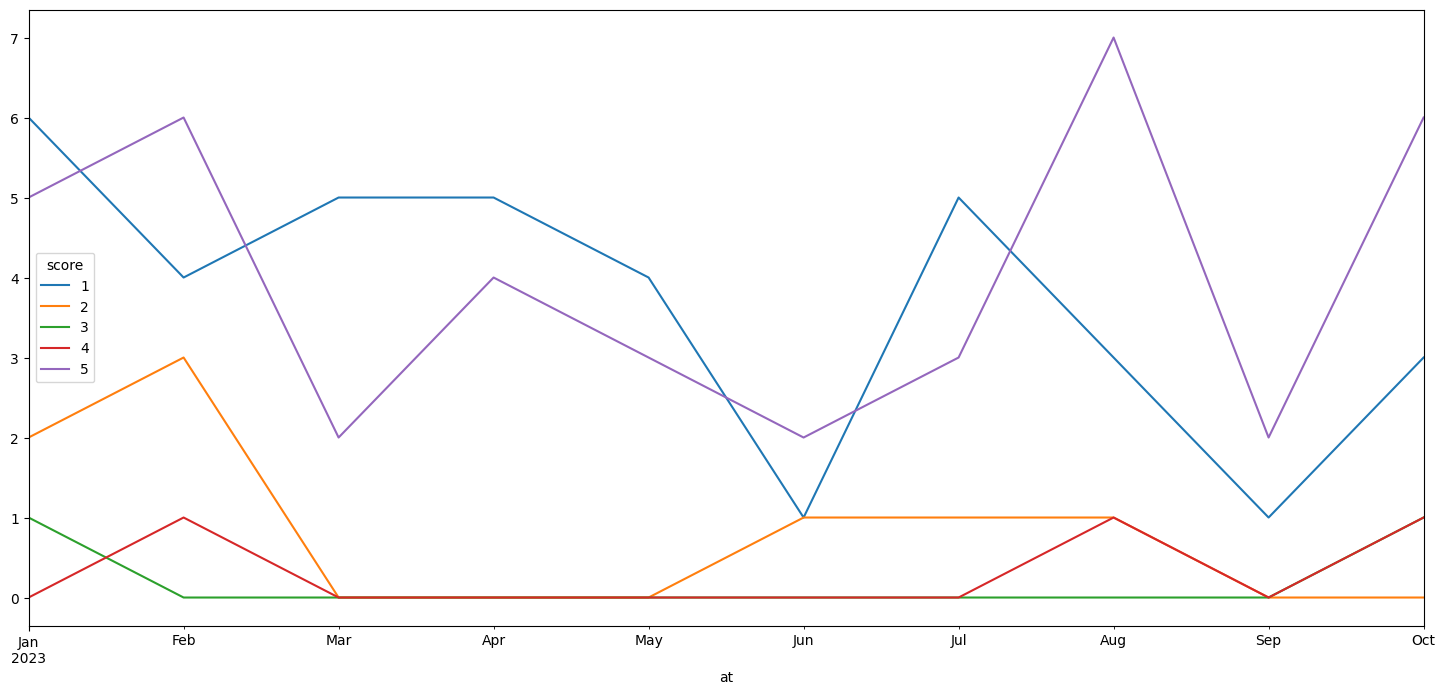

In [34]:
# グラフの表示
df_score_ex.plot(figsize=(18,8))

## 02.テキストマイニング（形態素解析

In [35]:
# 直近1カ月のレビューをデータフレーム化
df1 = df_bush[['at','content']]
df1 = df[(df['at'] > dt.datetime(2023,10,1)) & (df['at'] < dt.datetime(2023,10,31))]

テキストのみ抽出

In [36]:
df1 = df1[['content']]
df1 = df1.rename(columns={'content': 'text'})

MeCabで形態素解析を行う

In [37]:
#インストール
!pip install mecab-python3

#辞書インストール
!pip install unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658816 sha256=4ad6fa090f8bfdc9046f89fcebd25d4a29035041d5ced9f3f23535ec02c7ea6a
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


In [38]:
# MeCabで形態素解析を行う
import MeCab

def mecab_text(text):

    #MeCabのインスタンスを作成（辞書はmecab-ipadic-neologdを使用）
    mecab = MeCab.Tagger('-Owakati')

    #形態素解析
    node = mecab.parseToNode(text)

    #形態素解析した結果を格納するリスト
    wordlist = []

    while node:
        #名詞のみリストに格納する
        if node.feature.split(',')[0] == '名詞':
            wordlist.append(node.surface)
        #形容詞を取得、elifで追加する
        elif node.feature.split(',')[0] == '形容詞':
            wordlist.append(node.surface)
        #動詞を取得、elifで追加する
        #elif node.feature.split(',')[0] == '動詞':
        #    wordlist.append(node.surface)
        node = node.next
    return wordlist

# 形態素結果をリスト化し、データフレームdf1に結果を列追加する
df1['words'] = df1['text'].apply(mecab_text)

# 表示
df1


,text,words
0,Great,[Great]
1,Excelente,[Excelente]
2,They don't pay you for some loads and they pla...,"[They, don, t, pay, you, for, some, loads, and..."
3,Support is overseas and totally useless! You c...,"[Support, is, overseas, and, totally, useless,..."
4,Very good!!,"[Very, good]"
5,Nice app to move freight,"[Nice, app, to, move, freight]"
6,Uber Freight and Powerloop is trash now. They ...,"[Uber, Freight, and, Powerloop, is, trash, now..."
7,Very good,"[Very, good]"
8,"Rates could be better, but this is single hand...","[Rates, could, be, better, but, this, is, sing..."
9,Horrible carrier support. Everything is done i...,"[Horrible, carrier, support, Everything, is, d..."


In [39]:
pip install nlplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.9/967.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.8 MB/s eta 0:00:00


In [40]:
# nlplotで直近1カ月のレビューを可視化・分析
# 頻出単語
import nlplot

npt = nlplot.NLPlot(df1, target_col='words')

# top_nで頻出上位単語, min_freqで頻出下位単語を指定
stopwords = npt.get_stopword(top_n=0, min_freq=0)

npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
    stopwords=stopwords,
)


100%|██████████| 11/11 [00:00<00:00, 22149.47it/s]


In [41]:
npt.word_distribution(
    title='number of words distribution',
    xaxis_label='count',
)

In [42]:
# 単語数の分布
npt.treemap(
    title='Tree of Most Common Words',
    ngram=1,
    top_n=30,
    stopwords=stopwords,
)

100%|██████████| 11/11 [00:00<00:00, 22806.40it/s]


In [43]:
# ワードクラウド
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
)

In [44]:
# サンバースト
npt.sunburst(
    title='All sentiment sunburst chart',
    colorscale=True,
    color_continuous_scale='Oryel',
    width=800,
    height=600,
    save=True
)

AttributeError: ignored